In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load the Views Data

In [3]:
# Load data
df_views = pd.read_csv('/content/drive/MyDrive/Advanced_Data_Analytics_for_Business/FinalProject/Abgabe FINAL/Data/views2CAT_sampled_english_songs_20k.csv')

**views2CAT_sampled_english_songs_20k.csv:**

- year_df=df[df["year"]>=1960]
- english_df = year_df[year_df['language'] == 'en']
- english_df=english_df[english_df['tag'] != 'misc']
- word counts >= 100
- max_rows_per_viewrange = 5000
- Define the ranges for views:

2CAT view ranges: [(0, 100000), (100000, float('inf'))] with 10k each

# 2. Data Analysis

In [ ]:
# Find the lowest N values in the 'views' column
bottom_n = 10
bottom_views = df_views.nsmallest(bottom_n, 'views')
bottom_views

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
1963,Dangerous love,pop,Kat,2020,0,{},He was a time and place\nA quiet taste\nCan't ...,5448483,en,en,en
4089,Ene-Me,pop,Lerion,2021,0,{},Every time\nI step out and try\nWhy do you cal...,6905443,en,en,en
5800,Conversation with a Wasp,rock,Sucioperro,2006,0,{},I’ve been close to living since I last loved y...,7352633,en,en,en
6103,I Am The Island,rock,Feels Like July,2021,0,{},How can I escape this miserable week\nWhen I’v...,7281651,en,en,en
6377,Lemon Ice,rap,GONZA M.,2020,0,{},[Intro]\nSometimes I wish I (sometimes)\nSomet...,6020154,en,en,en
6697,Letting You Down,pop,Jakewolf,2020,0,{},I think i'm done letting you down\nI want you ...,5960303,en,en,en
7157,Notre Dame,pop,Carlos Simpson,2020,0,{},No more time to waste\nNo more life to waste m...,6387865,en,en,en
8970,Critical Moment,rock,Maika Barbero,2017,0,{},[Verse 1]\nNot just a simple day\nAfraid to be...,6727930,en,en,en
9416,The Everything,rock,Anecdata,2021,0,{},If you don't want to look stupid\nThen you sho...,6826492,en,en,en
133,They Dont Know LC Edition,rap,IGoByLC,2021,1,{},{Verse 1}\nThey don't know what I be on\nThey ...,7322206,en,en,en


In [ ]:
# Find the top N values in the 'views' column
top_n = 10
top_views = df_views.nlargest(top_n, 'views')
top_views

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
14392,Rap God,rap,Eminem,2013,17575634,{},"[Intro]\n""Look, I was gonna go easy on you not...",235729,en,en,en
11060,HUMBLE.,rap,Kendrick Lamar,2017,11181199,{},[Intro]\nNobody pray for me\nIt been that day ...,3039923,en,en,en
14488,Bohemian Rhapsody,rock,Queen,1975,9247817,{},[Intro]\nIs this the real life? Is this just f...,1063,en,en,en
12158,Bad and Boujee,rap,Migos,2016,9168421,"{""Lil Uzi Vert""}","[Intro: Offset & Future]\nYou know, young rich...",2845980,en,en,en
12957,Gods Plan,rap,Drake,2018,9107059,{},[Intro]\nAnd they wishin' and wishin'\nAnd wis...,3315890,en,en,en
19017,SICKO MODE,rap,Travis Scott,2018,9078511,{Drake},"[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun i...",3876994,en,en,en
16845,XO TOUR Llif3,rap,Lil Uzi Vert,2017,8351197,{},"[Intro]\nAre you alright?\nI'm alright, I'm qu...",3003630,en,en,en
16234,1-800-273-8255,rap,Logic,2017,7955642,"{Khalid,""Alessia Cara""}","[Pre-Chorus: Logic]\nI've been on the low, I b...",3050777,en,en,en
14403,Work,pop,Rihanna,2016,7871555,{Drake},"[Chorus: Rihanna]\nWork, work, work, work, wor...",2398213,en,en,en
18501,Fuckin Problems,rap,A$AP Rocky,2012,7724360,"{Drake,""Kendrick Lamar"",""A\\$AP Rocky"",""2 Chai...","[Chorus: 2 Chainz, Drake, 2 Chainz & Drake, A$...",93539,en,en,en


# 3. Preprocessing

In [4]:
# Drop all rows with NaN values in the entire DataFrame
df_views = df_views.dropna()

In [5]:
# Add a new column 'views_success' based on 'views' ranges
df_views['views_success'] = pd.cut(df_views['views'],
                                  bins=[0, 100000, float('inf')],
                                  labels=['fail', 'success'])

# Display the DataFrame with the new column
print(df_views)

                                title   tag  \
0            Aint That Lovin You Baby   pop   
1      Good Luck Ft. Christian Burgos   pop   
2                       Black Suit On  rock   
3                  She’s Got the Look  rock   
4                     Backwater Blues   pop   
...                               ...   ...   
19995            Strong Will Continue   rap   
19996            Dont Fear The Reaper  rock   
19997                    Feeling Good    rb   
19998                      Lemon Tree   pop   
19999   Hard Knock Life Ghetto Anthem   rap   

                                    artist  year   views  \
0                              Rod Stewart  1990     113   
1                             Luna Pirates  2019     213   
2      Original LA Cast of The Black Suits  2019     142   
3                              Guttermouth  2001    5872   
4                     Kenny Wayne Shepherd  2011     135   
...                                    ...   ...     ...   
19995          

<ipython-input-5-8b454ba271d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_views['views_success'] = pd.cut(df_views['views'],


In [ ]:
# Add a new column 'views_success' based on 'views' ranges
#df['views_success'] = pd.cut(df['views'],
#                                  bins=[0, 1000, 100000, float('inf')],
#                                  labels=['fail', 'part success', 'success'])

# Display the DataFrame with the new column
#print(df)

In [ ]:
df_views.value_counts('views_success')

views_success
success    10000
fail        9990
dtype: int64

In [6]:
# clean the lyrics from unnecessary signs etc.

# Function to clean text
def clean_text(text):
    # Remove English stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    # Remove the text in brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Replace line breaks and multiple whitespaces with a single space
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespaces
    text = text.strip()
    return text

# Apply the cleaning function to your text column
df_views['lyrics'] = df_views['lyrics'].apply(clean_text)

print(df_views['lyrics'])

0        Know love baby Know love baby know love baby e...
1        Wish good luck know one best life Hey! hope fi...
2        Button shirt Buckle belt Haven’t looked like s...
3        likes read like tv checking good friend steve ...
4        Said rains five days skies turn dark night Sai...
                               ...                        
19995    stay focused Looking straight forward world be...
19996    times come Here, they're gone Seasons fear rea...
19997    Birds flying high, know feel Sun sky, know fee...
19998    I'm sittin' boring room another rainy Sunday a...
19999    Take bass line Uh-huh, Jigga Uh-huh, uh-huh, u...
Name: lyrics, Length: 19999, dtype: object


In [7]:
# Mapping labels to numbers
label_mapping = {"fail": 0, 'success': 1}

df_views['numeric_labels'] = df_views['views_success'].map(label_mapping)

In [8]:
# Define the number of samples for each numeric label
num_samples_per_label = 8000

# Sample data randomly to ensure equal distribution
sampled_df = df_views.groupby('numeric_labels').apply(lambda x: x.sample(n=num_samples_per_label, random_state=42))

# Reset the index of the resulting DataFrame
sampled_df.reset_index(drop=True, inplace=True)

# Display the sampled DataFrame with the 'views' and 'numeric_label' columns
print(sampled_df[['views', 'numeric_labels']])

        views numeric_labels
0        1134              0
1         448              0
2        9123              0
3          36              0
4         421              0
...       ...            ...
15995  421314              1
15996  167069              1
15997  115324              1
15998  583587              1
15999  193394              1

[16000 rows x 2 columns]


In [ ]:
sampled_df.value_counts('numeric_labels')

numeric_labels
0    8000
1    8000
dtype: int64

# 4. Train Test Split and DistilBERT Model Loading

In [9]:
# Train/Test Split
train_df, test_df = train_test_split(sampled_df, test_size=0.2, random_state=42, stratify=sampled_df['numeric_labels'])

# Convert train and test data to lists
train_lyrics = train_df['lyrics'].tolist()
train_labels = torch.tensor(train_df['numeric_labels'].tolist())

test_lyrics = test_df['lyrics'].tolist()
test_labels = torch.tensor(test_df['numeric_labels'].tolist())

# Tokenizer and Model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
class SongsDataset(Dataset):
    def __init__(self, songs, labels, tokenizer):
        self.songs = songs
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        song = str(self.songs[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            song,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:
# Create datasets
train_dataset = SongsDataset(train_lyrics, train_labels, tokenizer)
test_dataset = SongsDataset(test_lyrics, test_labels, tokenizer)

# Data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Model Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 6
warmup_steps = 200

In [13]:
# Initialize lists to hold the average training and evaluation loss for each epoch
train_loss_per_epoch = []
eval_loss_per_epoch = []

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight_decay for L2 regularization
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6


  0%|          | 0/800 [00:00<?, ?it/s]<ipython-input-18-0a39f4068fff>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 800/800 [10:06<00:00,  1.32it/s]


Train Loss: 0.5082034659385681


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


Eval Loss: 0.4660845958441496
Epoch 2/6


100%|██████████| 800/800 [09:56<00:00,  1.34it/s]


Train Loss: 0.4150193052180111


100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


Eval Loss: 0.4644213185086846
Epoch 3/6


100%|██████████| 800/800 [09:59<00:00,  1.33it/s]


Train Loss: 0.36146171058528126


100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


Eval Loss: 0.46871391400694845
Epoch 4/6


100%|██████████| 800/800 [09:56<00:00,  1.34it/s]


Train Loss: 0.3085700493352488


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


Eval Loss: 0.4993450925126672
Epoch 5/6


100%|██████████| 800/800 [09:56<00:00,  1.34it/s]


Train Loss: 0.26355861383257434


100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


Eval Loss: 0.5668389714509249
Epoch 6/6


100%|██████████| 800/800 [09:56<00:00,  1.34it/s]


Train Loss: 0.22594479565974324


100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


Eval Loss: 0.5855966785736382


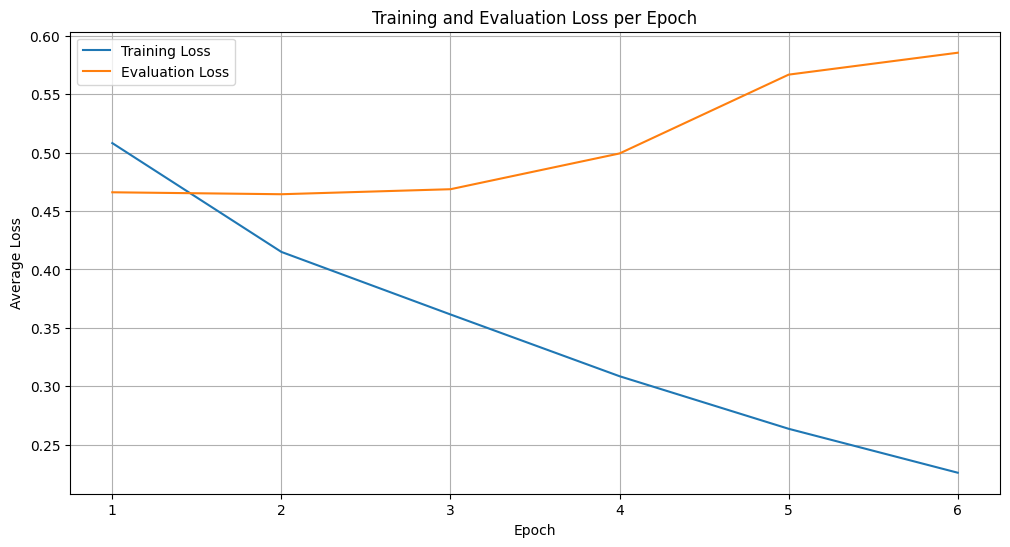

In [ ]:
import matplotlib.pyplot as plt

# Training Loop
print("Starting Training")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_train_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate average loss for this epoch and append to the list
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss}")
    train_loss_per_epoch.append(avg_train_loss)

    # Evaluation loop
    model.eval()
    total_eval_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader):  # Use the test_dataloader for evaluation
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = nn.CrossEntropyLoss()(logits, labels)
            total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(test_dataloader)
    print(f"Eval Loss: {avg_eval_loss}")
    eval_loss_per_epoch.append(avg_eval_loss)

    model.train()

# Plotting the training and evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label='Training Loss')
plt.plot(range(1, num_epochs + 1), eval_loss_per_epoch, label='Evaluation Loss')
plt.title('Training and Evaluation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

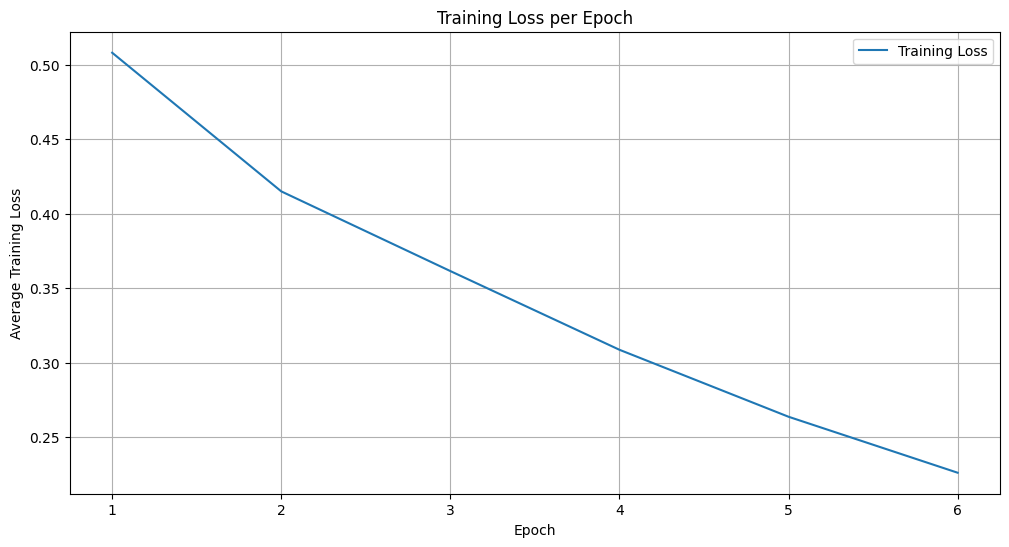

In [ ]:
# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the entire model
path_to_save = '/content/drive/MyDrive/Advanced_Data_Analytics_for_Business/FinalProject/Models'
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, f'{path_to_save}/equal16k_6epochs_trained_model_2classes_views.pth')

In [15]:
# Load the model
#path_to_model = '/content/drive/MyDrive/Advanced_Data_Analytics_for_Business/FinalProject/Abgabe FINAL/Models and Embeddings/equal16k_6epochs_trained_model_2classes_views.pth'
#model.load_state_dict(torch.load(path_to_model))
#model.to(device)

# 6. Model Evaluation

<ipython-input-18-0a39f4068fff>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


Accuracy: 0.78625
F1 Score: 0.7861534349104516


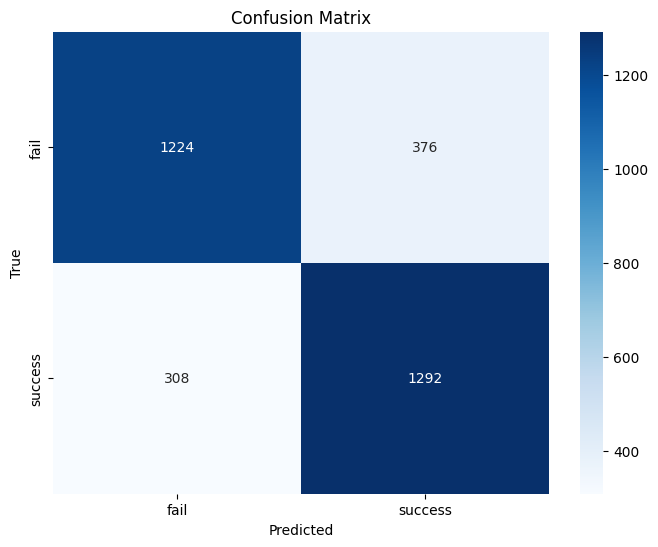

Classification Report:
              precision    recall  f1-score   support

        fail       0.80      0.77      0.78      1600
     success       0.77      0.81      0.79      1600

    accuracy                           0.79      3200
   macro avg       0.79      0.79      0.79      3200
weighted avg       0.79      0.79      0.79      3200



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns



# Prepare the model for evaluation
model.eval()
predictions = []
true_labels = []

# Disable gradient calculations
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, predictions)
label_names = list(label_mapping.keys())
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_names))